# In-Memory Model Predictions

In production machine learning, **serving a model and generating predictions** is a core task.  

Before deploying a model to an endpoint or converting it to TensorFlow Lite, it's important to understand **how to make predictions directly in memory**:

- Load a trained model
- Preprocess input images
- Generate predictions
- Interpret the outputs

This notebook demonstrates **in-memory predictions** on the 5-flowers dataset, using the model trained in Chapter 7:

1. Load a saved model locally
2. Load and preprocess images from TFDS
3. Generate predictions in memory
4. Compare predictions with true labels
5. Visualize sample predictions

By the end of this notebook, you will be able to **generate predictions without any external service or REST endpoint**, which is the first step toward production ML workflows.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Model (or Train Lightweight Model)

IMG_SIZE = 224
MODEL_PATH = "saved_model/flowers_model" #Update path to your saved model (or leave as-is to generate a new one)
# Example: MODEL_PATH = "..\\07_training\\model_registry\\v_20260215_185521\\" 
# --> ".." traverses one parent directory
# --> The double backslashes are needed on Windows (the first backslash protects the second from Python interpretation)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded saved model.")
    IMG_SIZE = model.input_shape[1]
    print(f"Model expects: {model.input_shape}")
else:
    print("Saved model not found. Training lightweight model for demo...")
    (ds_train, ds_val), ds_info = tfds.load(
        "tf_flowers",
        split=["train[:80%]", "train[80%:]"],
        as_supervised=True,
        with_info=True
    )
    NUM_CLASSES = ds_info.features["label"].num_classes

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    def preprocess(image, label):
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0
        return image, label
    
    ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
    model.fit(ds_train, epochs=1)
    
    # Save the model for reuse
    os.makedirs("saved_model", exist_ok=True)
    model.save(MODEL_PATH)



Loaded saved model.
Model expects: (None, 224, 224, 3)


In [2]:
# Load Validation Dataset

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

CLASS_NAMES = ds_info.features["label"].names

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess).batch(32)

for images, labels in ds_val.take(1):
    preds = model.predict(images)
    break


1/1 [==============================] - 1s 978ms/step


In [3]:
# Make In-Memory Predictions

# Take one batch for demonstration
for images, labels in ds_val.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    images_np = images.numpy()
    labels_np = labels.numpy()
    break


1/1 [==============================] - 0s 275ms/step


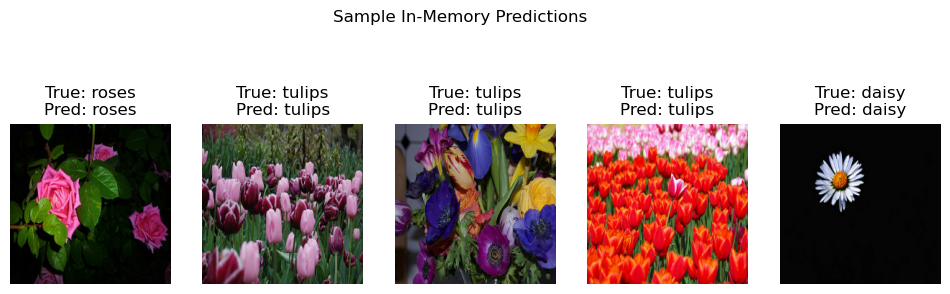

In [4]:
# Visualize Predictions

plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images_np[i])
    plt.title(f"True: {CLASS_NAMES[labels_np[i]]}\nPred: {CLASS_NAMES[pred_labels[i]]}")
    plt.axis("off")
plt.suptitle("Sample In-Memory Predictions")
plt.show()

